# Prediction model of Player Position through Machine Learning


#### Introduction: describe which dataset and variables you selected and why
For this research I used the following dataset: 
FIFA 18 Complete Player Dataset (https://www.kaggle.com/datasets/thec03u5/fifa-18-demo-player-dataset)

The dataset consists of 17k players and 70+ attributes from the 2018 edition of FIFA

The variables that I chose: 
- Preferred Positions
- Aggression
- Finishing 
- Ball control
- Vision
- Strenght
- Stamina
- Sprint speed

I chose for this variables, because based on this



##### Content
Every player featuring in FIFA 18
70+ attributes
Player and Flag Images
Playing Position Data
Attributes based on actual data of the latest EA's FIFA 18 game
Attributes include on all player style statistics like Dribbling, Aggression, GK Skills etc.
Player personal data like Nationality, Photo, Club, Age, Wage, Salary etc.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression #remember, this is linear regression model from sk-learn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn import datasets  
from sklearn.tree import  DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [25]:
df = pd.read_csv('data/fifadata.csv')
df.head()

/var/folders/jn/dbm52hjn5115_s2wz8xcvxq40000gn/T/ipykernel_78570/822390763.py:1: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/fifadata.csv')


,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning:

In [26]:
#choosing fields
df = df[['Aggression','Crossing', 'Curve', 'Dribbling', 'Finishing','Free kick accuracy', 'Heading accuracy', 'Long shots',
                  'Penalties', 'Shot power', 'Volleys', 'Short passing', 'Long passing','Interceptions', 'Marking', 'Sliding tackle',
                  'Standing tackle','Strength', 'Vision', 'Acceleration', 'Agility', 'Reactions', 'Stamina', 'Balance', 'Ball control',
                  'Composure','Jumping','Sprint speed', 'Positioning','Preferred Positions']]

In [27]:
#removing GK position data as it is obvious based on his skills
df = df[df['Preferred Positions'].str.strip() != 'GK']
df.isnull().values.any()


False

In [28]:
#find all the different positions on the field   
pos = df['Preferred Positions'].str.split().apply(lambda x: x[0]).unique()
print(pos)

['ST' 'RW' 'LW' 'CDM' 'CB' 'RM' 'CM' 'LM' 'LB' 'CAM' 'RB' 'CF' 'RWB' 'LWB']


In [29]:
# copy the structure
df_new = df.copy()
df_new.drop(df_new.index, inplace=True)

for i in pos:
    df_temp = df[df['Preferred Positions'].str.contains(i)]
    df_temp['Preferred Positions'] = i
    df_new = df_new.append(df_temp, ignore_index=True)

/var/folders/jn/dbm52hjn5115_s2wz8xcvxq40000gn/T/ipykernel_78570/4192031265.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Preferred Positions'] = i
/var/folders/jn/dbm52hjn5115_s2wz8xcvxq40000gn/T/ipykernel_78570/4192031265.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(df_temp, ignore_index=True)


In [30]:
#adding some cell values which are in form of '72+5' instead of numerical values
cols = [col for col in df.columns if col not in ['Preferred Positions']]
for i in cols:
    df_new[i] = df_new[i].apply(lambda x: eval(x) if isinstance(x,str) else x)

## Exploratory data analysis

Text(22, 100, 'Mixed Attributes')

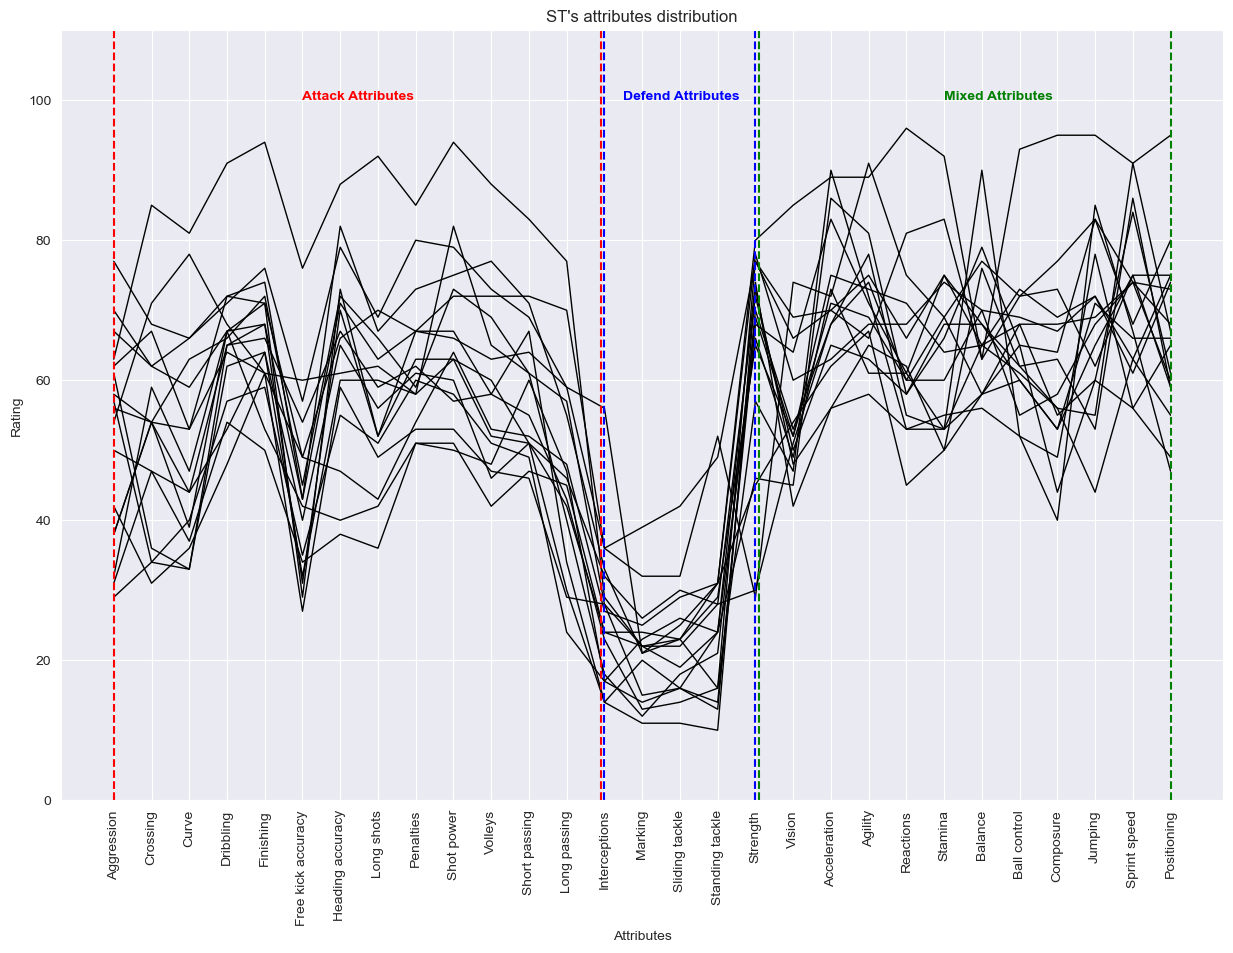

In [31]:
#plotting the graph only for striker position
sns.set_style("darkgrid")
fig, ax = plt.subplots()
df_new_ST = df_new[df_new['Preferred Positions'] == 'ST'].iloc[::200,:-1]
df_new_ST.T.plot.line(color = 'black', figsize = (15,10), legend = False, ylim = (0, 110), title = "ST's attributes distribution", ax=ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation=90)

for ln in ax.lines:
    ln.set_linewidth(1)

ax.axvline(0, color='red', linestyle='--')   
ax.axvline(12.9, color='red', linestyle='--')

ax.axvline(13, color='blue', linestyle='--')
ax.axvline(17, color='blue', linestyle='--')

ax.axvline(17.1, color='green', linestyle='--')
ax.axvline(28, color='green', linestyle='--')

ax.text(5, 100, 'Attack Attributes', color = 'red', weight = 'bold')
ax.text(13.5, 100, 'Defend Attributes', color = 'blue', weight = 'bold')
ax.text(22, 100, 'Mixed Attributes', color = 'green', weight = 'bold')


The data we are analyzing appears to show a clear pattern, but there are some instances where the results deviate significantly from what is expected. This is likely due to the fact that some players perform exceptionally well in their positions while others do not. By normalizing the data, the pattern should become more consistent among players in the same position. 

In [33]:
#changing the values of preferred positions into numerical form
mapping = {'ST': 1, 'RW': 1, 'LW': 1, 'RM': 1, 'CM': 1, 'LM': 1, 'CAM': 1, 'CF': 1, 'CDM': 0, 'CB': 0, 'LB': 0, 'RB': 0, 'RWB': 0, 'LWB': 0}
df_new_bin = df_new.replace({'Preferred Positions': mapping})
X = df_new_bin.iloc[:,0:29].values
Y = df_new_bin.iloc[:,29].values

## Predictive model


Random Forest is a machine learning algorithm that uses multiple decision trees to improve the accuracy of predictions. It is a method that selects random subsets of data and features to train each tree, and then makes a final prediction by taking a majority vote of all trees. It is known for handling high dimensional data, providing feature importance and being less prone to overfitting. It is widely used in various fields and considered as one of the most accurate algorithm available.

In [34]:
#splitting dataset into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

In [49]:

# import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)

# fit the model
rfc.fit(X_train, Y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check accuracy score 
from sklearn.metrics import accuracy_score

# Print accuracy
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.7921


In [36]:
#predicting the test set results
y_pred = clf.predict(X_test)
#y_new_pred = clf.predict([[82,	44,	56,	69,	39,	61,	88,	65,	70,	74,	58,	79,	85,	90,	84,	88,	88,	85,	74,	62,	60,	86,	73,	52,	75,	84,	85,	72,	38]])
Lr_acc = clf.score(X_test, Y_test)
print ('Logistic Regression Accuracy: {}'.format(Lr_acc))

Logistic Regression Accuracy: 0.8651623555310952


In [39]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[1824  323]
 [ 412 2892]]


## Evaluation


In [41]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      2147
           1       0.90      0.88      0.89      3304

    accuracy                           0.87      5451
   macro avg       0.86      0.86      0.86      5451
weighted avg       0.87      0.87      0.87      5451



In the markdown cell above, we see that class 0 has precision of 0.82, recall of 0.85 and f1-score of 0.83 and class 1 has precision of 0.9, recall of 0.88 and f1-score of 0.89. The accuracy score is also provided which is 0.87.

It could be interpreted as the model is performing well on the classification problem, with high precision, recall, and f1-score for both classes, and high accuracy overall. 

## Conclusion


I applied feature engineering in order to normalize the model, given that some players have extremely high scores compared to others. The model has high accuracy scores for predicting player positions.